In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from datetime import timedelta

# Opening and preparing the data

In [39]:
def prepare_data(order_items_path, order_path, products_path):
    """
    Load and prepare sales data from CSV files.

    Args:
        order_items_path (str): File path for the order items CSV file.
        order_path (str): File path for the orders CSV file.
        products_path (str): File path for the products CSV file.

    Returns:
        pd.DataFrame: DataFrame containing aggregated sales data by product category and purchase date.
    """
    
    # Read the csv's
    try:
        order_items = pd.read_csv(order_items_path)
        orders = pd.read_csv(order_path)
        products = pd.read_csv(products_path)
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None
    
    try:
        # Merge the datasets
        merge = pd.merge(order_items, orders, on="order_id")
        merge = pd.merge(merge, products, on="product_id")
        
        # Convert timestamps to date
        merge["order_purchase_timestamp"] = pd.to_datetime(merge["order_purchase_timestamp"]).dt.date
        
        # Aggregate sales data and sum the sales
        sales = merge.groupby(["product_category_name", "order_purchase_timestamp"])["order_item_id"].sum().reset_index()
        sales.rename(columns={"order_purchase_timestamp": 'date', "order_item_id": "num_sales"}, inplace=True)
        sales["date"] = pd.to_datetime(sales["date"])
        
        return sales
    
    except KeyError as e:
        print(f"Error processing data: {e}")
        return pd.DataFrame()

In [40]:
sales = prepare_data("orders.csv", "order_items.csv", "products.csv")
# Check if DataFrame works
sales.head(5)

,product_category_name,date,num_sales
0,agro_industria_e_comercio,2017-01-23,3
1,agro_industria_e_comercio,2017-01-31,1
2,agro_industria_e_comercio,2017-02-05,1
3,agro_industria_e_comercio,2017-02-08,1
4,agro_industria_e_comercio,2017-02-12,1


In [41]:
len(sales[sales['product_category_name'] == 'utilidades_domesticas'])
sales['product_category_name'].value_counts()

moveis_decoracao                                 607
esporte_lazer                                    603
beleza_saude                                     602
cama_mesa_banho                                  598
informatica_acessorios                           593
                                                ... 
cds_dvds_musicais                                 12
portateis_cozinha_e_preparadores_de_alimentos     11
pc_gamer                                           8
fashion_roupa_infanto_juvenil                      8
seguros_e_servicos                                 2
Name: product_category_name, Length: 73, dtype: int64

# Functions

In [42]:
def check_if_data_exists(data):
    """
    Check if there is sufficient data available for forecasting.

    Parameters:
    - data: pandas Series object, the data to be checked.

    Returns:
    - bool: True if there is sufficient data, False otherwise.
    """
    return not data.empty and not data.isna().all()

In [43]:
def plot_forecasts(dates, forecasts, title):
    """
    Plot forecasted sales over time.

    Parameters:
    - dates (list): List of datetime objects representing the dates.
    - forecasts (list): List of forecasted sales values corresponding to the dates.
    - title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(dates, forecasts, marker="o", linestyle="-", color="r")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Forecasted Sales")
    plt.grid(True)
    plt.show()

In [44]:
def train_forest_model(data):
    """
    Train a Random Forest regressor model (version two) to predict sales based on date features.
    Version two of the model employs a straightforward approach without cross-validation. 
    It directly trains the Random Forest model on the entire dataset and uses default hyperparameters

    Parameters:
    - data (DataFrame): DataFrame containing the sales data with a 'date' column and a 'sales' column.

    Returns:
    - RandomForestRegressor: Trained Random Forest regressor model.
    """
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    data = data.copy()
    
    # Extracting date-related features for the Random Forest model
    data['day_of_week'] = data['date'].dt.dayofweek
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    
    X = data[['day_of_week', 'month', 'day']]
    y = data['num_sales']
    
    # Training the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    return model

In [45]:
def prediction_rf(model, data, days=14, buffer_days=7):
    """
    Forecast sales using a trained Random Forest regressor model.

    Parameters:
    - model (RandomForestRegressor): Trained Random Forest regressor model.
    - data (DataFrame): DataFrame containing the sales data with a 'date' column.
    - days (int): Number of days into the future to forecast.
    - buffer_days (int): Number of days to buffer before starting the forecast.

    Returns:
    - predictions (array): Array of forecasted sales values.
    - future_dates (DatetimeIndex): DatetimeIndex of future dates for which the sales are forecasted.
    """
    
    # Get the current date
    last_date = data['date'].max()
    
    # Create future dates for prediction including the buffer period
    future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=days + buffer_days, freq='D')
    
    # Create a DataFrame with future date features
    future_data = pd.DataFrame({
        'day_of_week': future_dates.dayofweek,
        'month': future_dates.month,
        'day': future_dates.day
    })
    
    # Predictions for the future dates, considering the buffer period
    predictions = model.predict(future_data.iloc[buffer_days:])
    
    return predictions, future_dates[buffer_days:]

In [46]:
def fit_arima(series):
    """
    Fit an ARIMA model to the given time series data and make forecasts.

    Parameters:
    - series (pandas Series): Time series data to fit the ARIMA model.

    Returns:
    - forecast_after_buffer (array): Array containing forecasts for the next 14 periods (after 7 day buffer).
    """
    
     # Check if sufficient data is available for ARIMA model
    if not check_if_data_exists(series):
        print("No data available for ARIMA model.")
        return None
    
    # Automatically fit an optimal ARIMA model
    model = auto_arima(series, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True, d=1, D=1, trace=True,
                       error_action='ignore', suppress_warnings=True, stepwise=True)
    fitted_model = model.fit(series)
    
    # Forecasting the next 21 periods
    forecast = fitted_model.predict(n_periods=21)
    
    # Buffer zone (7 days)
    forecast_after_buffer = forecast[7:]
    
    return forecast_after_buffer

# Forecasting

### RANDOM FOREST

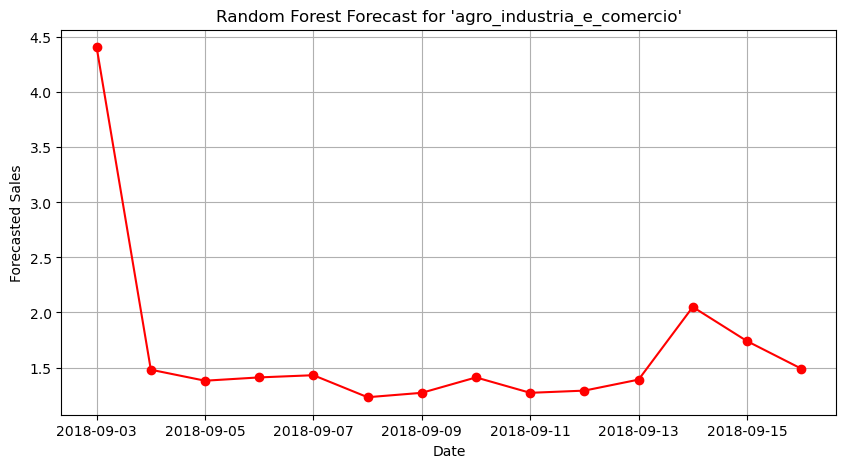

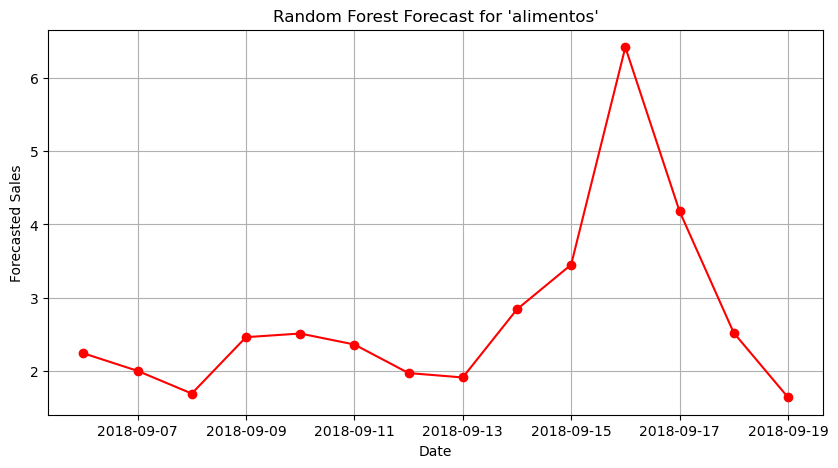

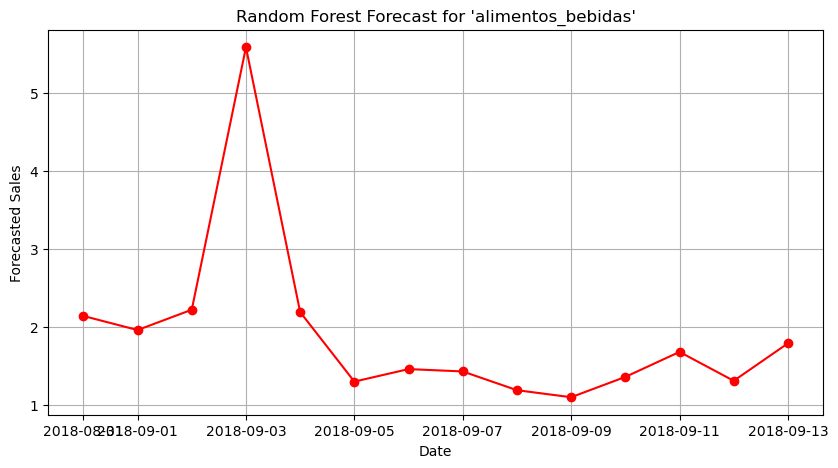

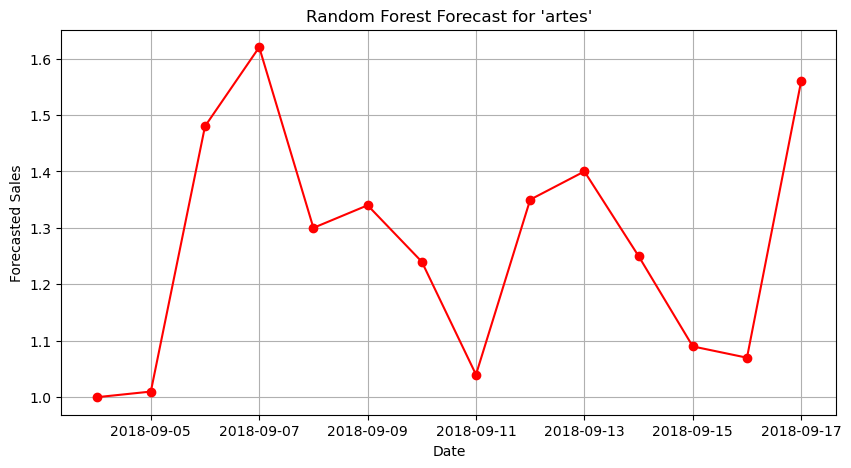

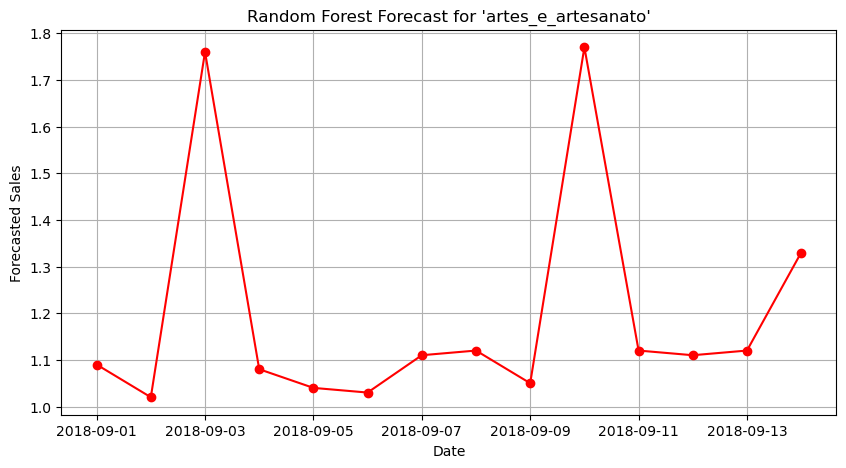

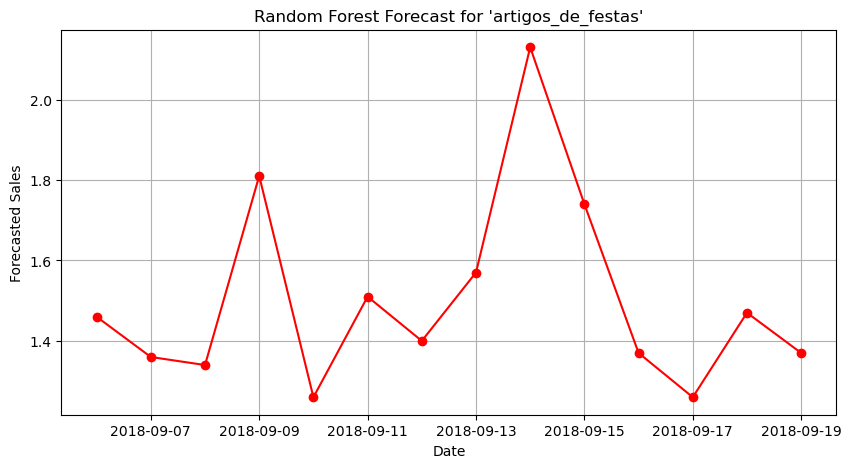

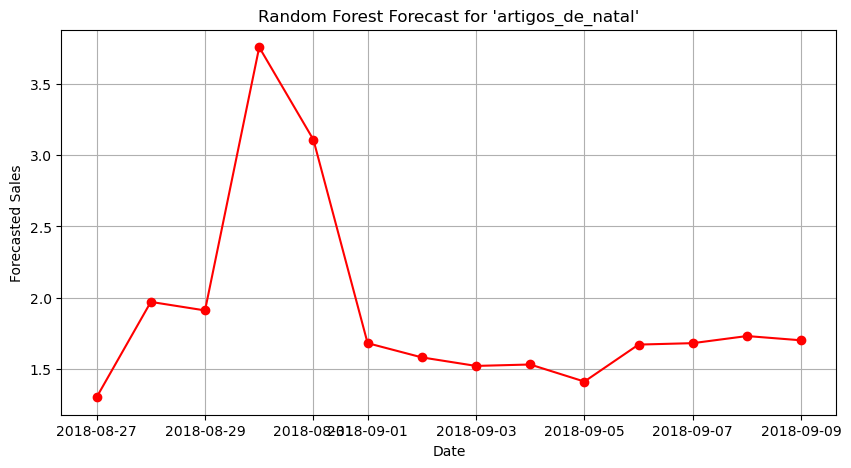

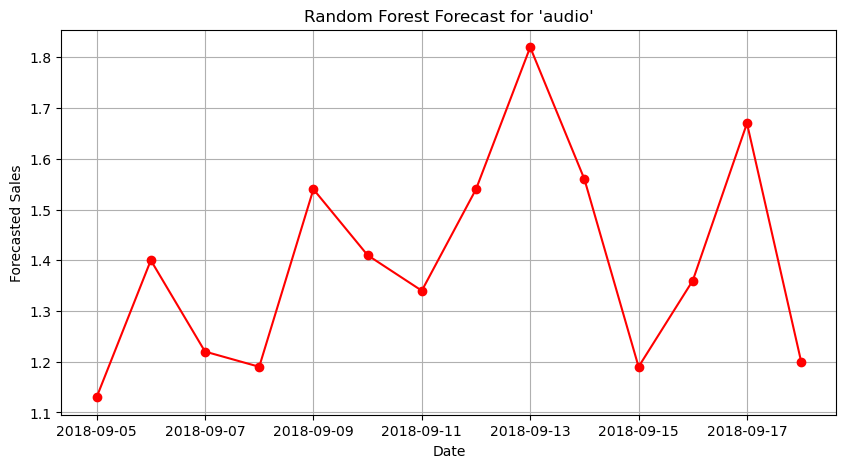

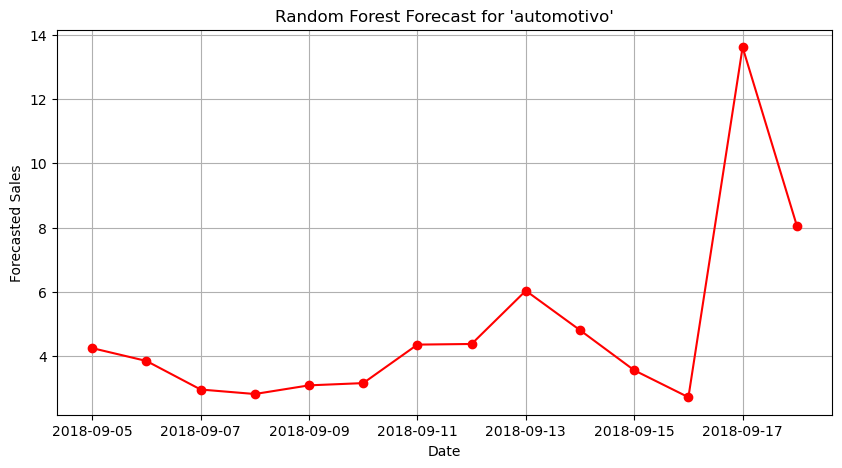

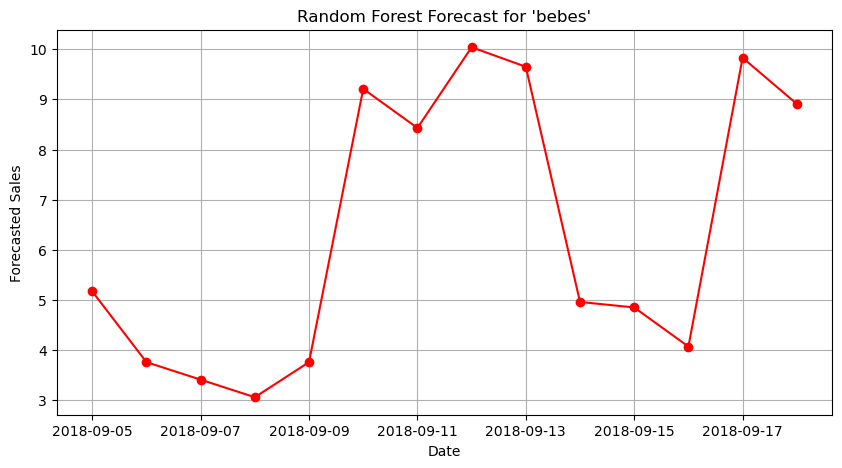

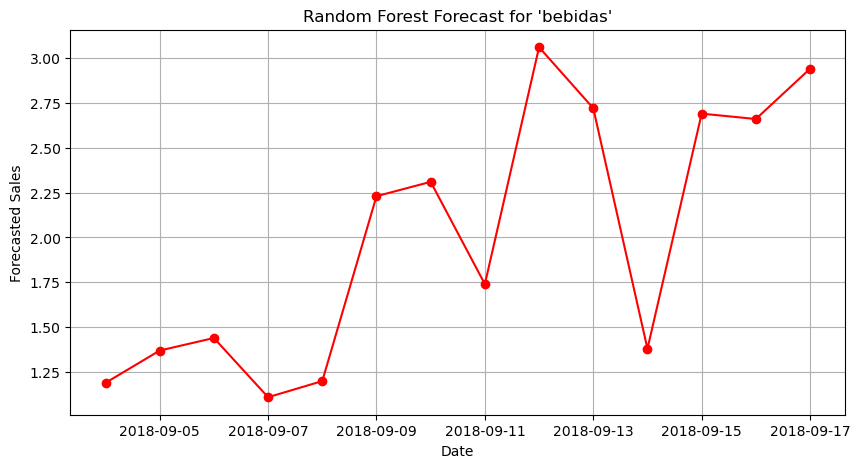

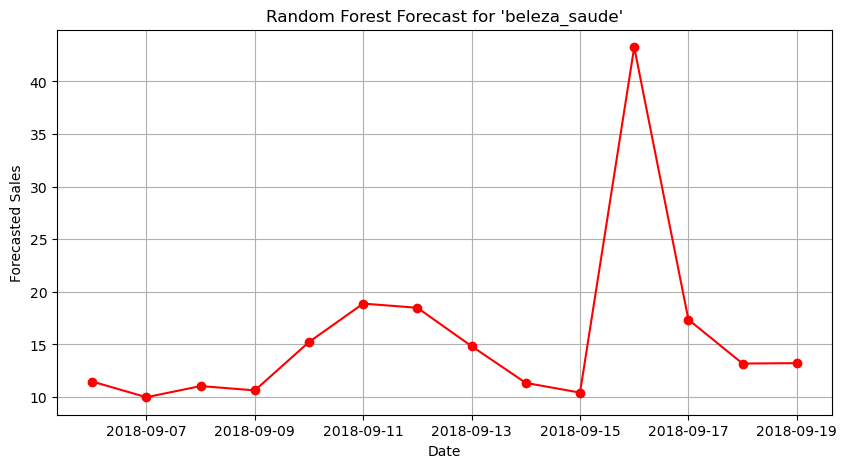

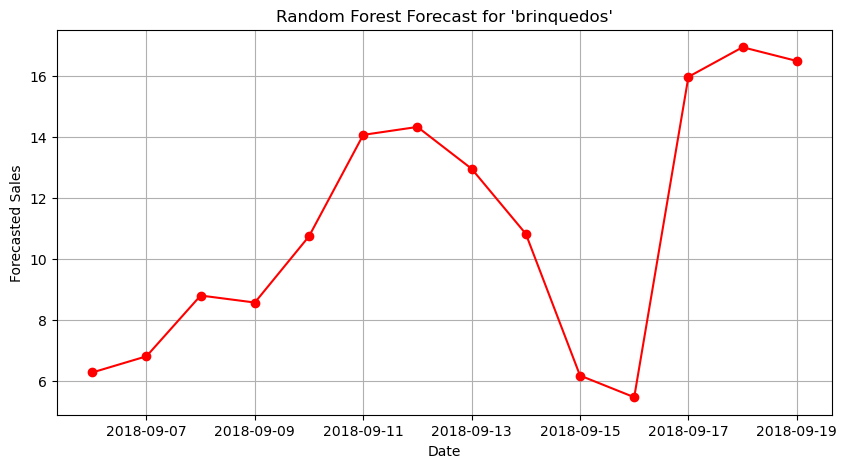

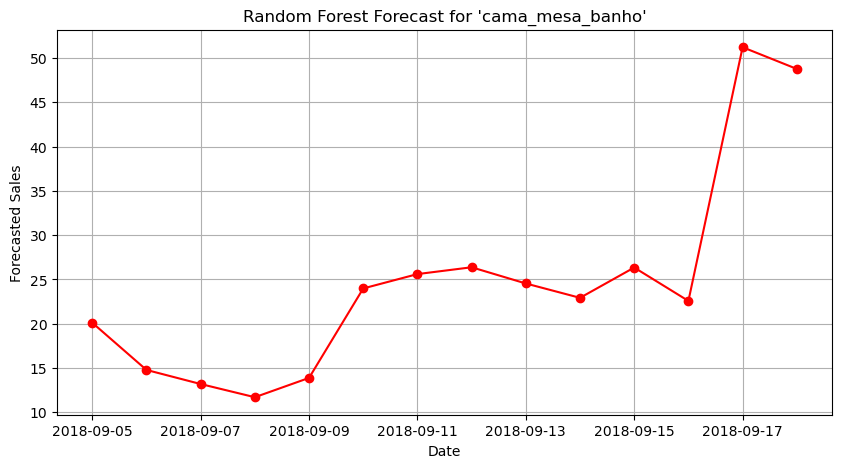

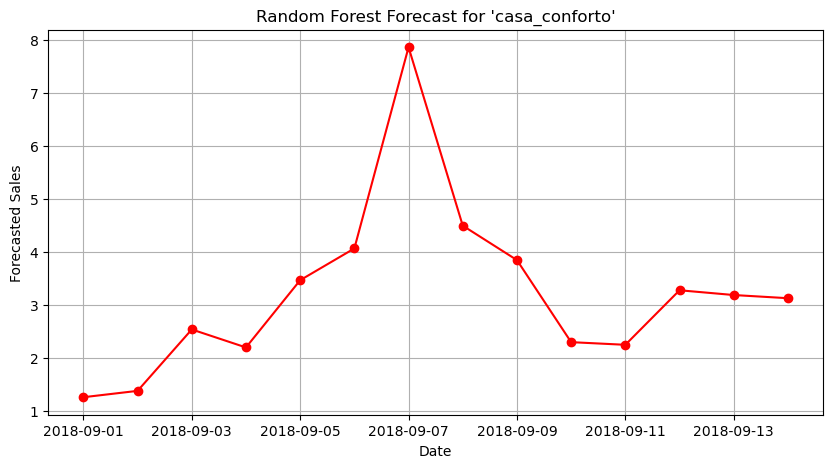

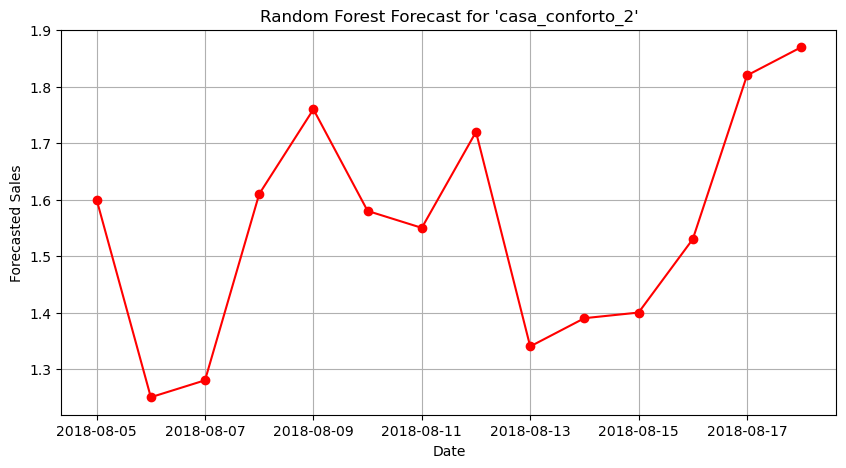

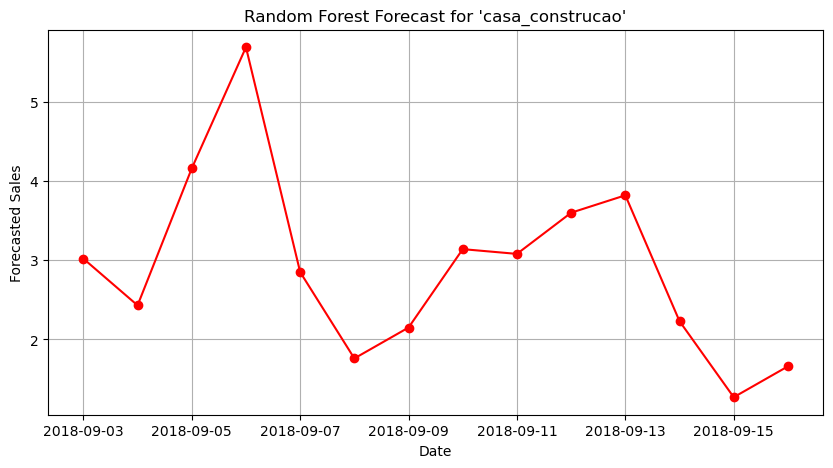

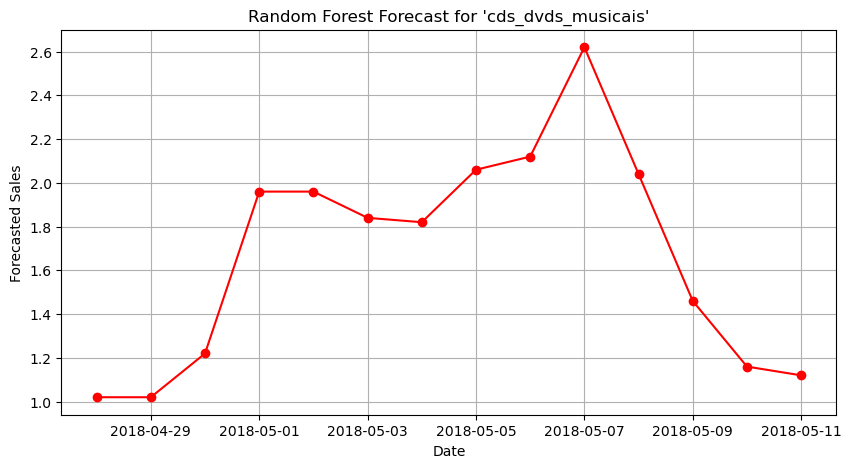

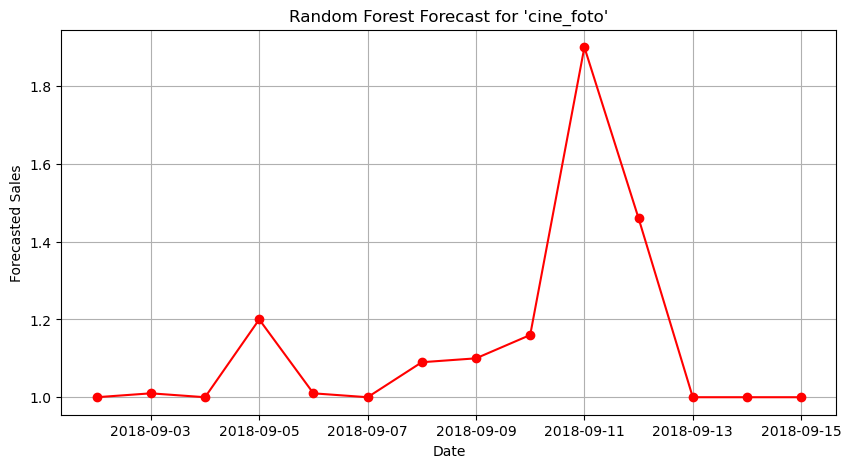

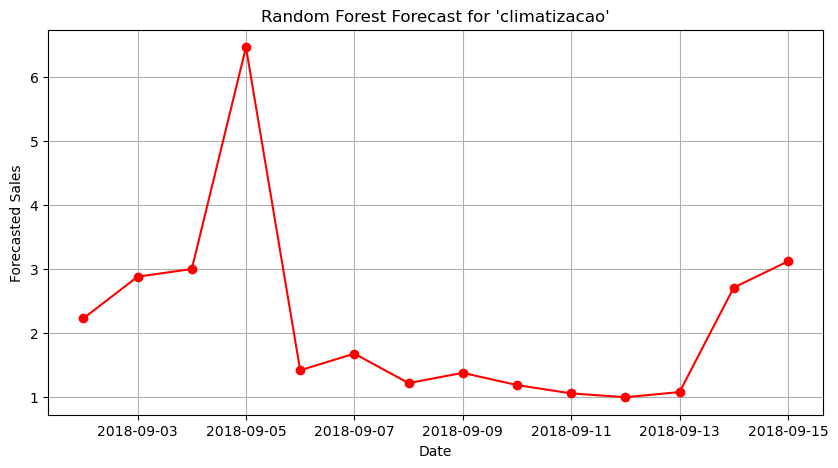

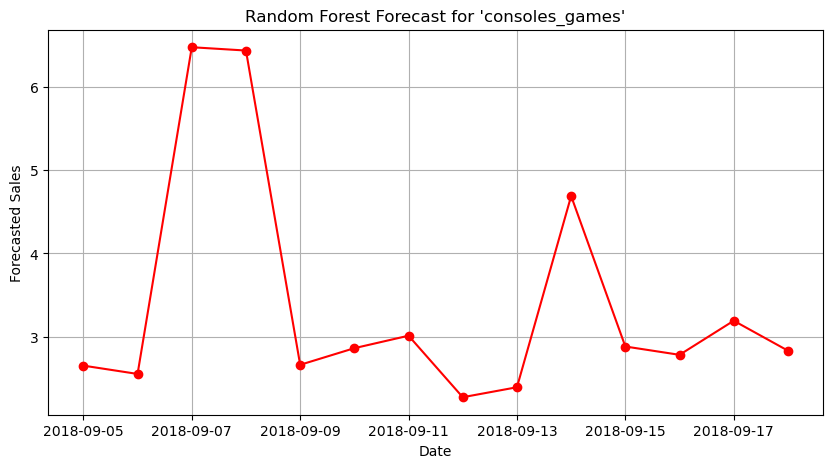

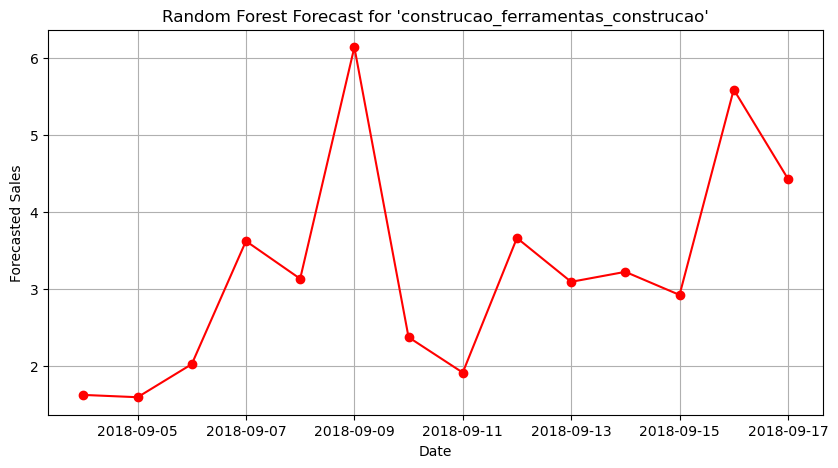

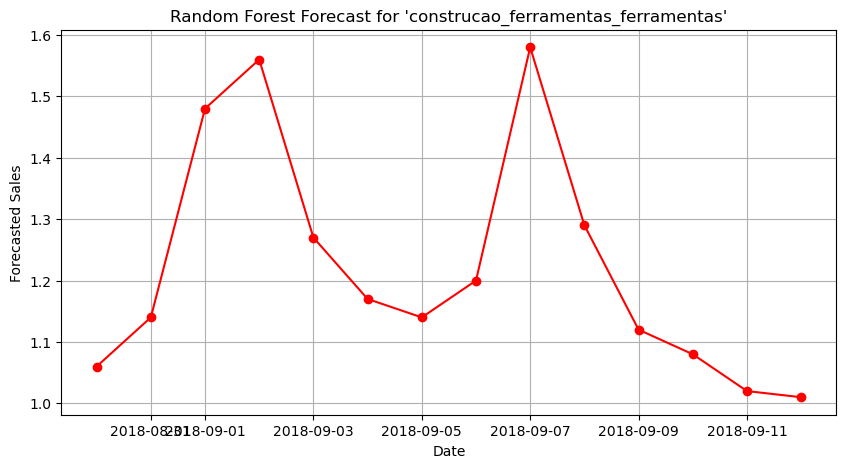

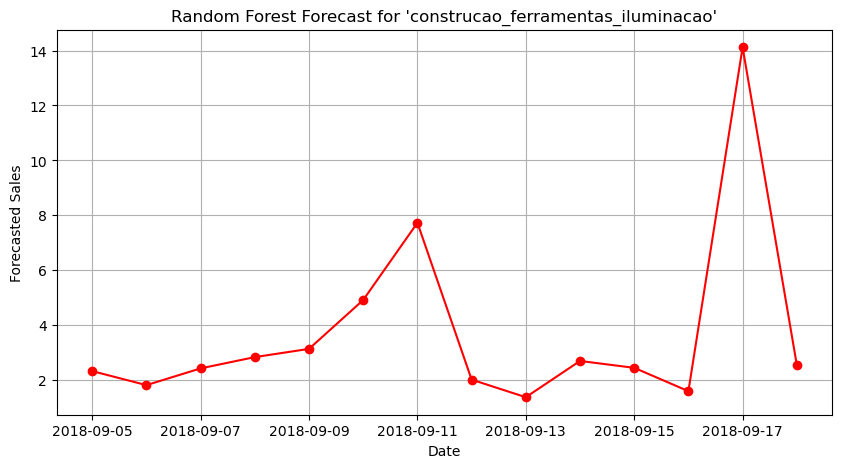

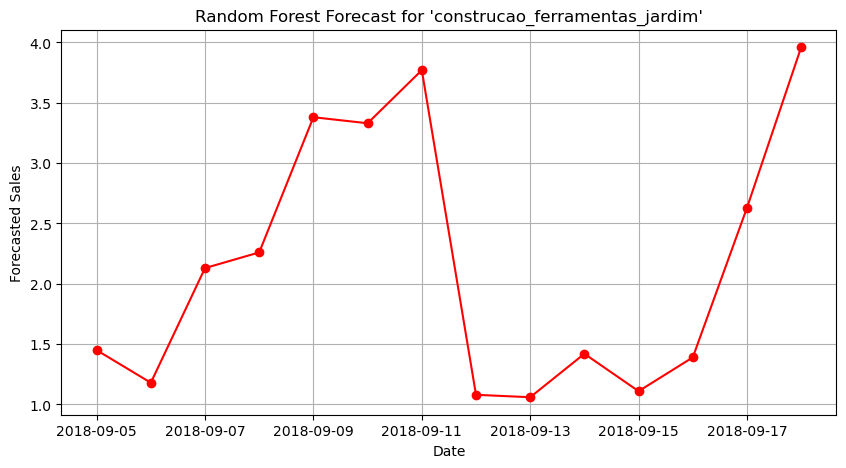

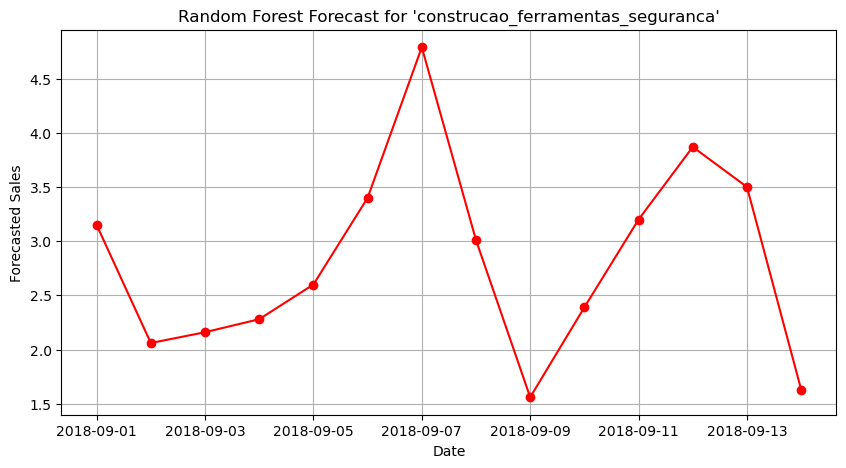

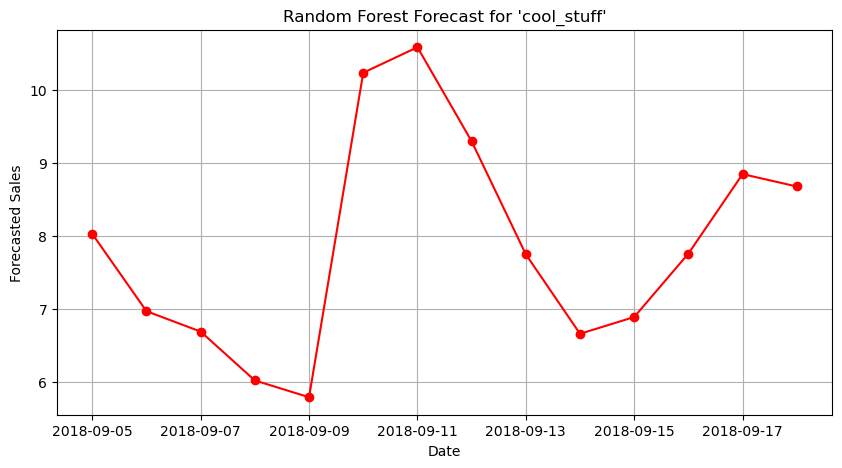

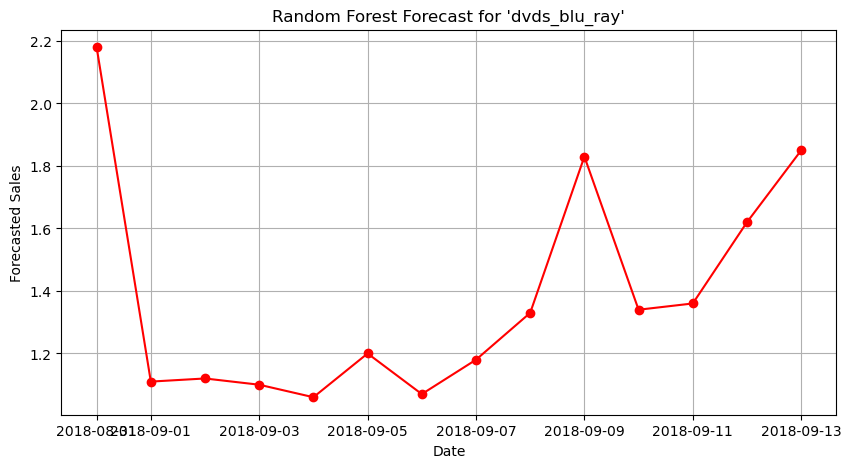

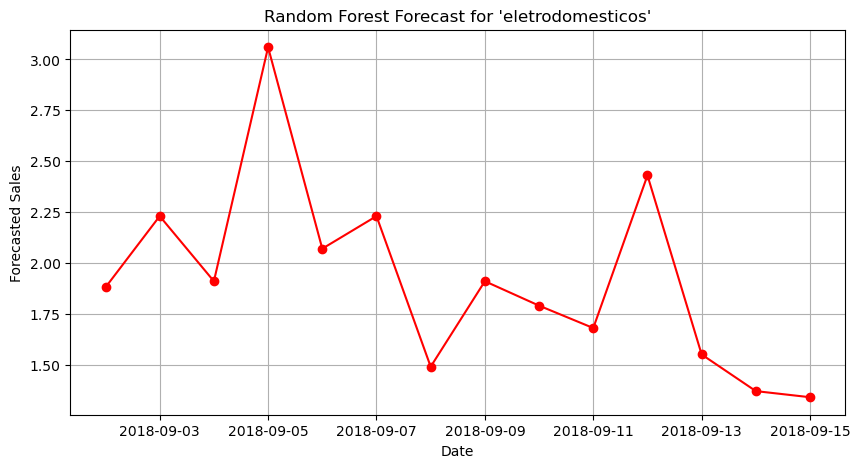

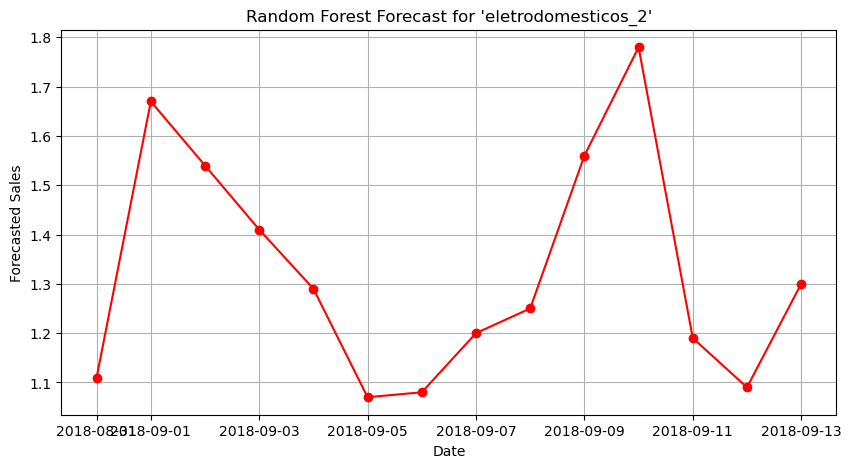

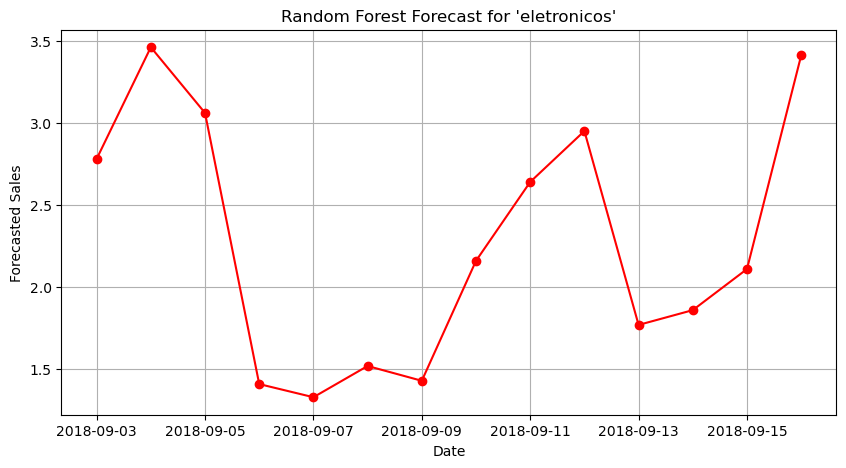

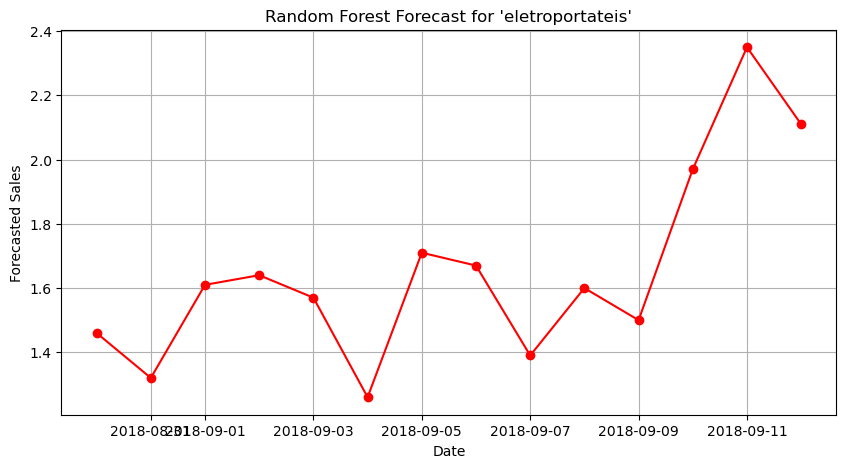

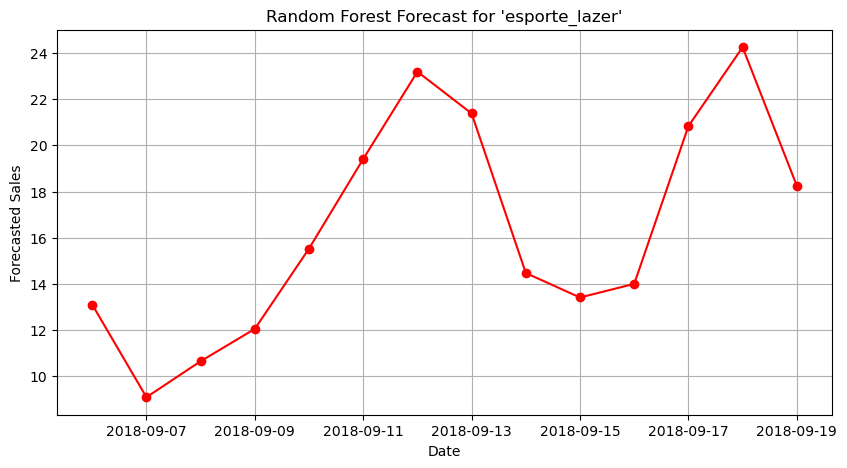

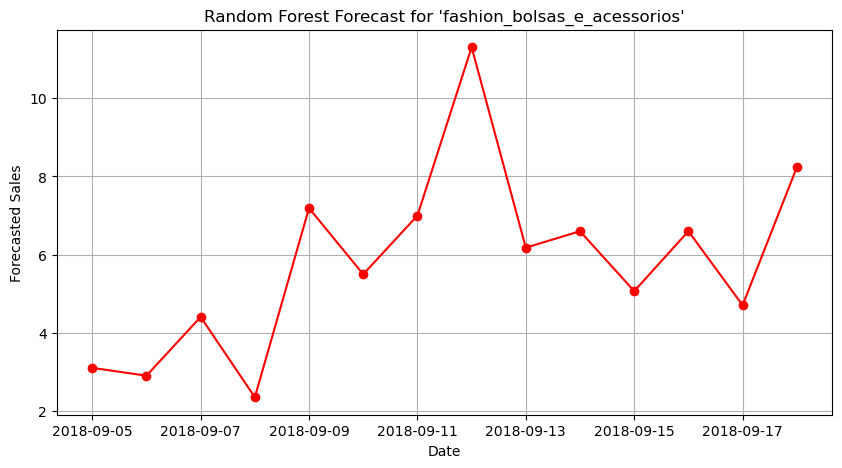

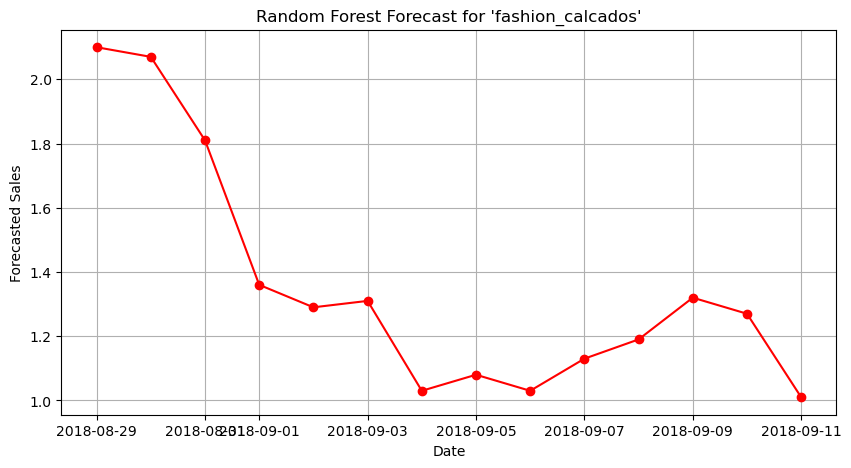

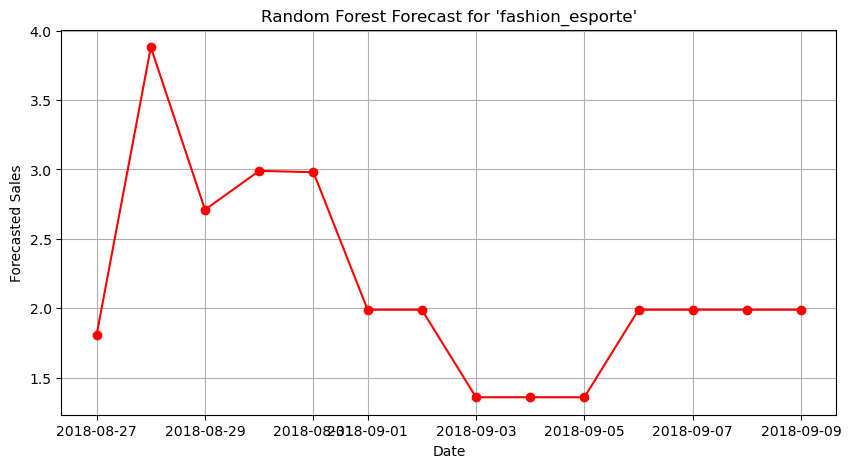

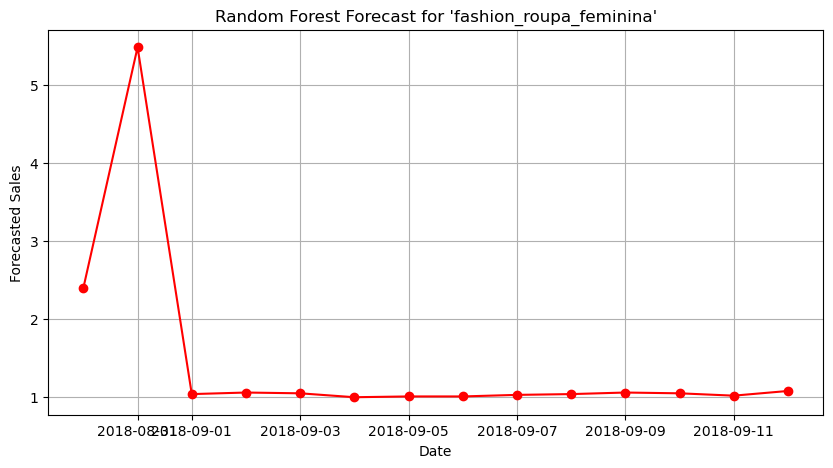

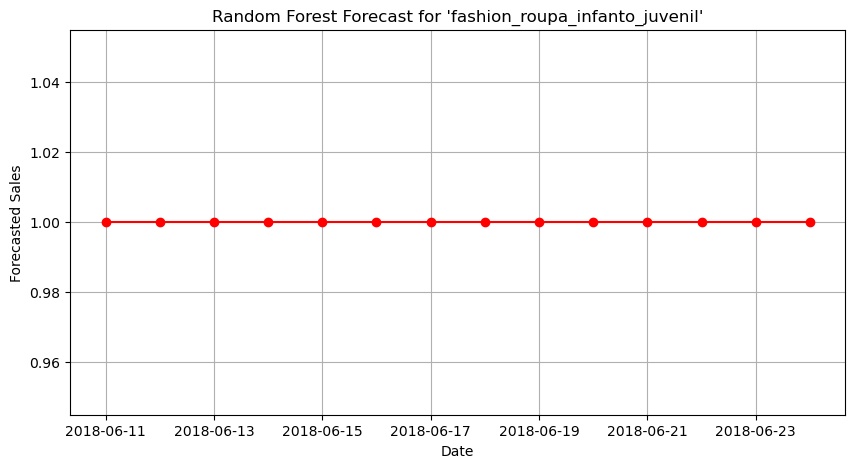

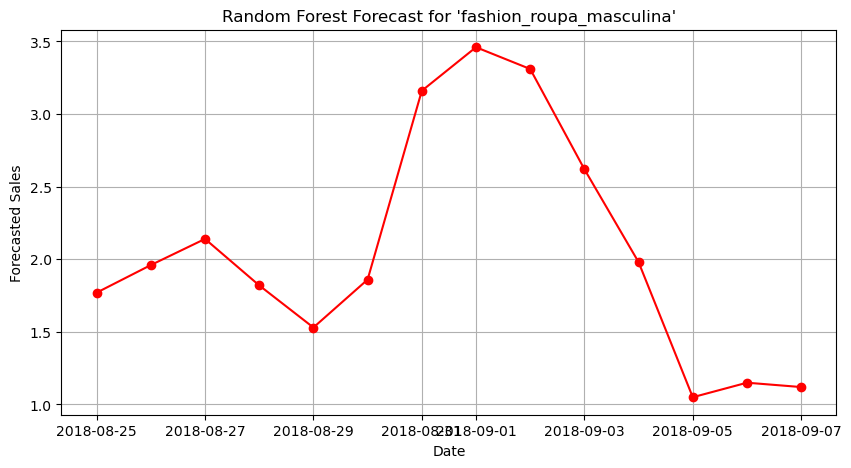

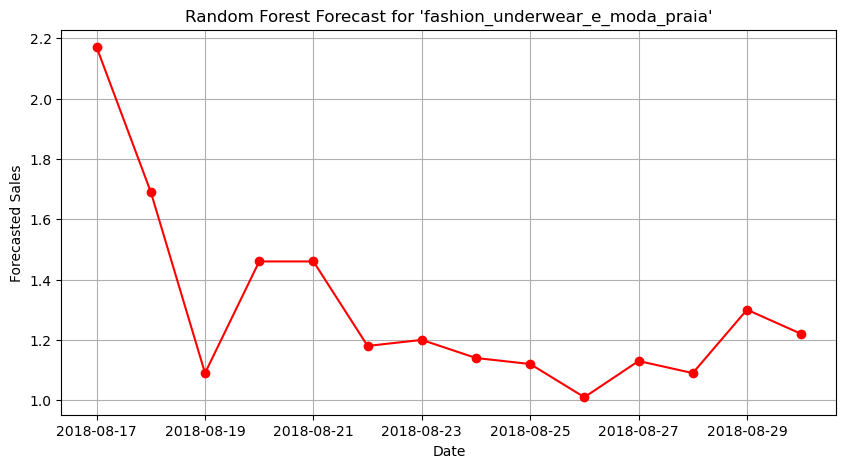

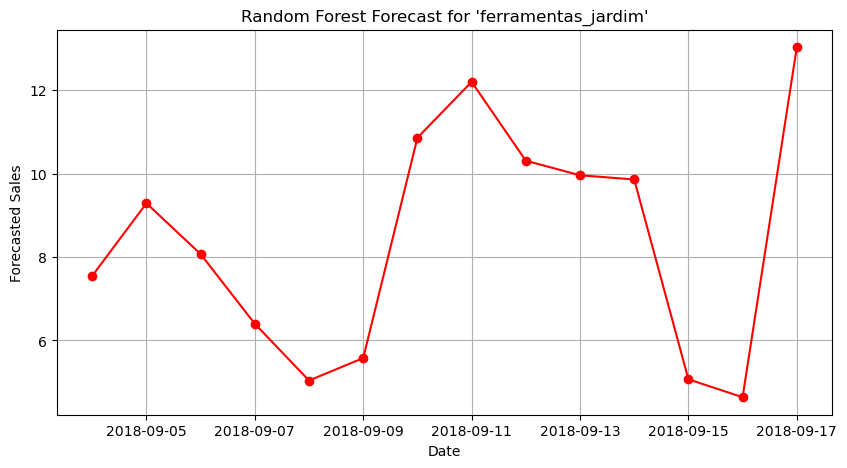

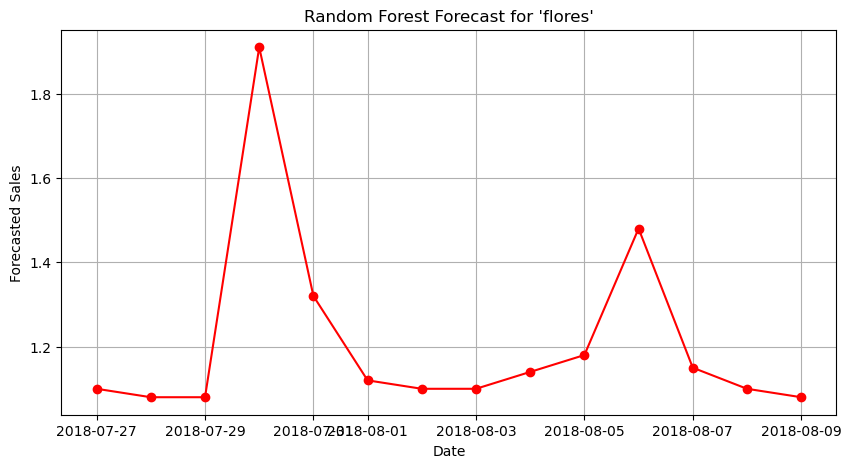

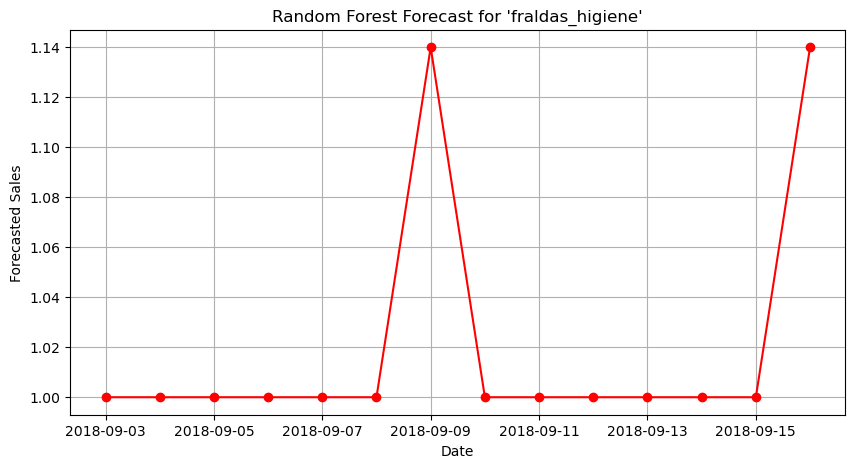

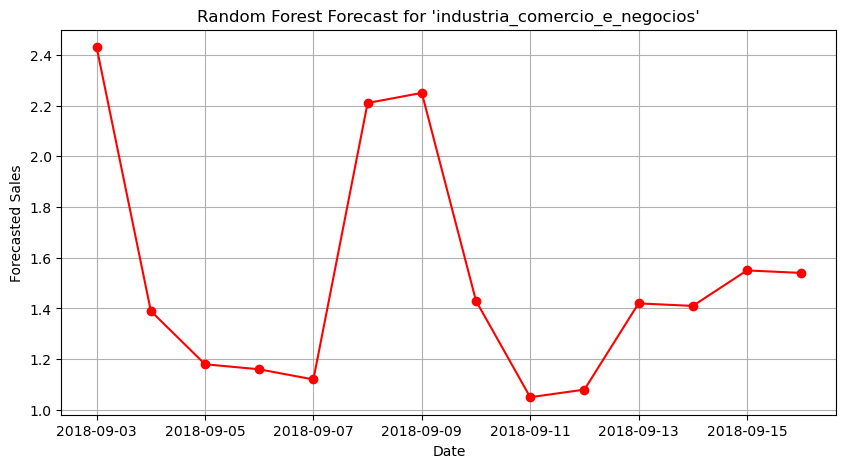

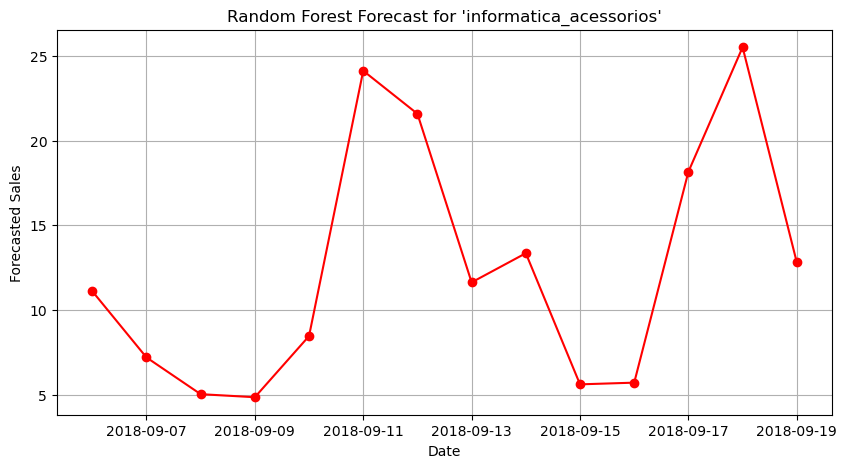

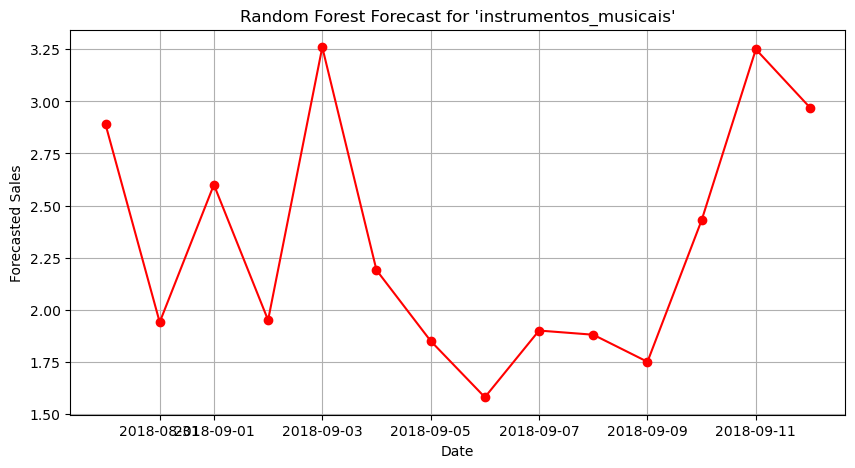

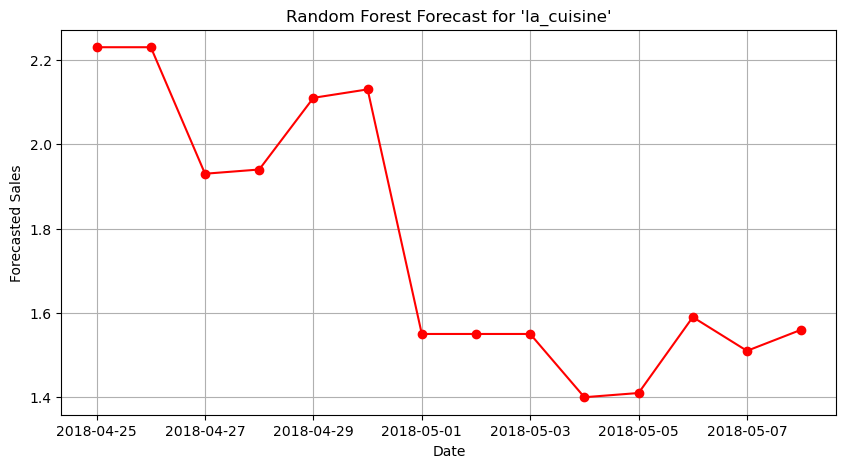

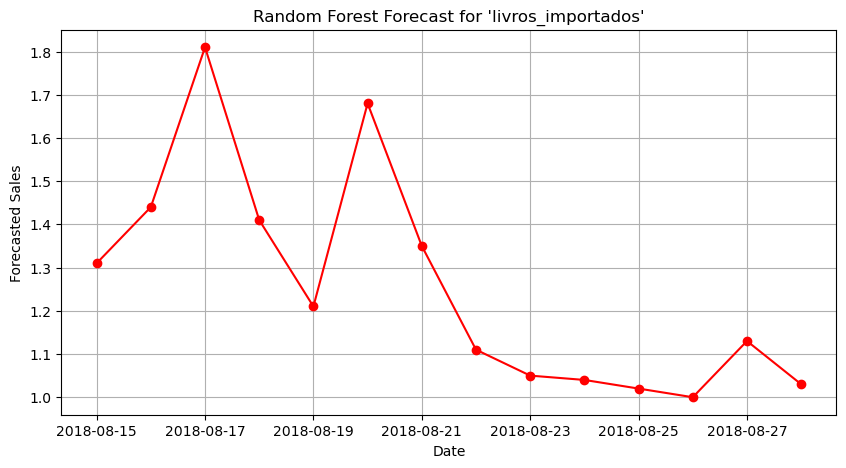

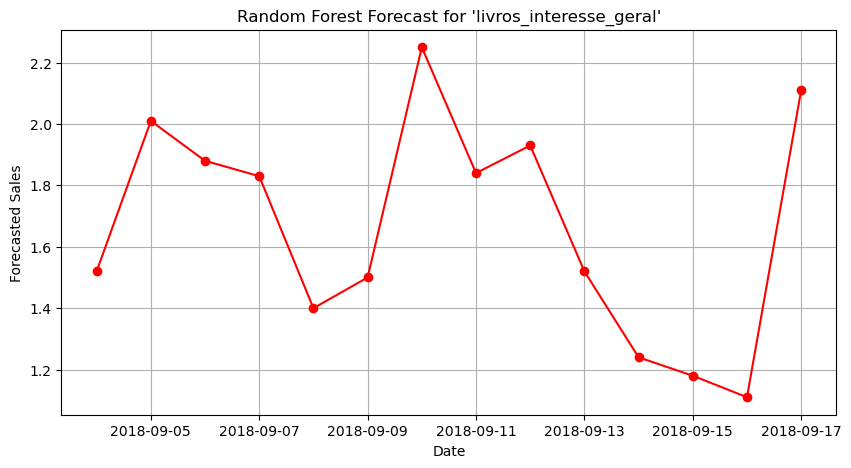

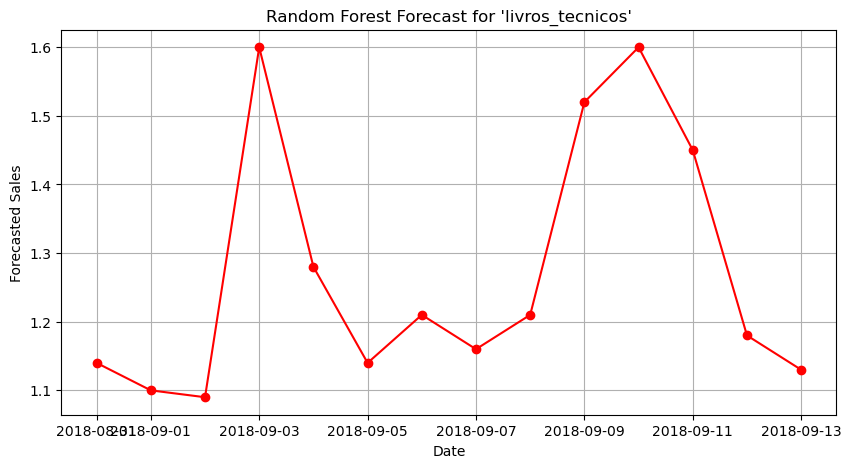

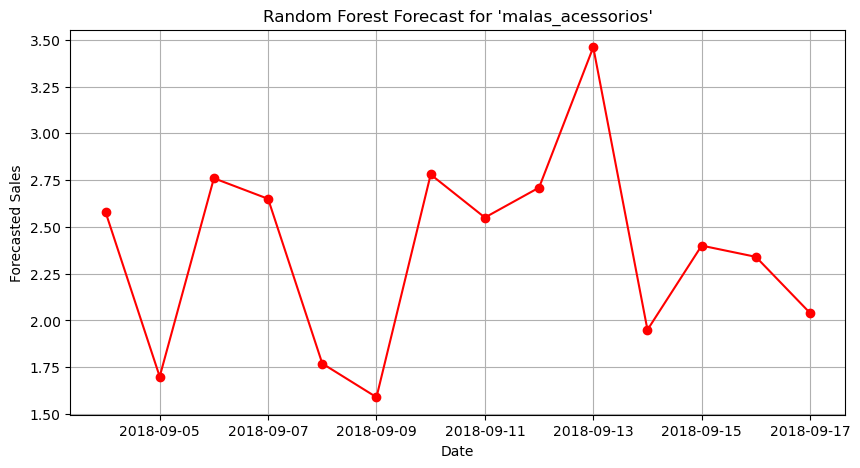

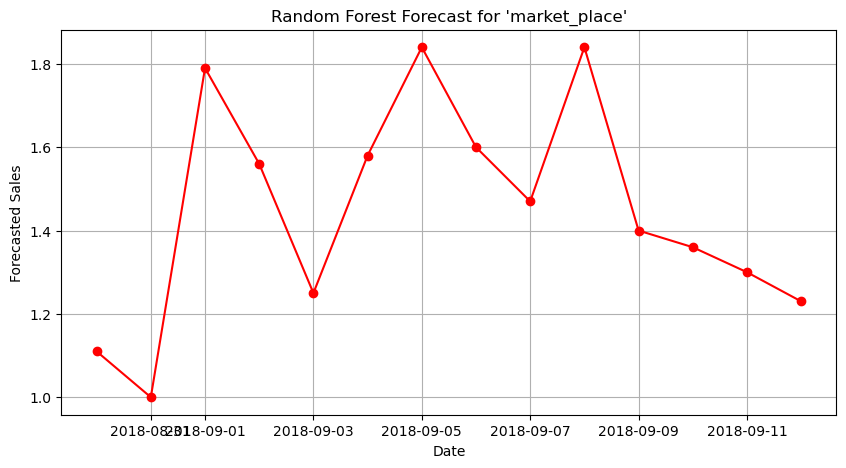

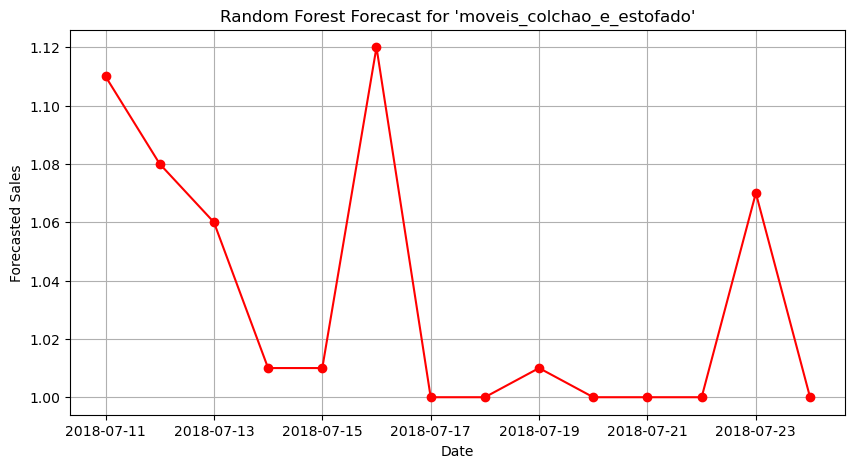

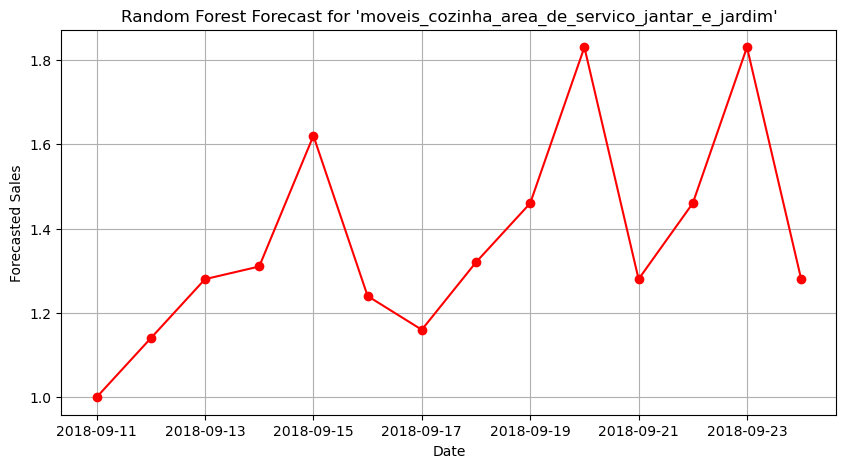

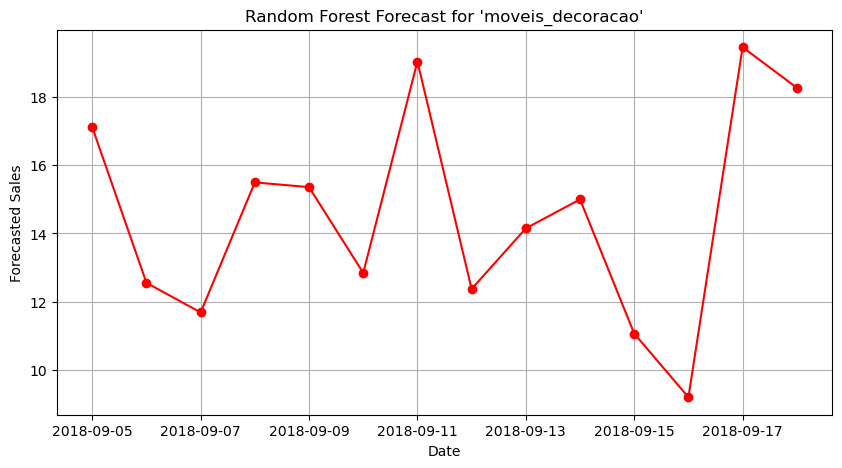

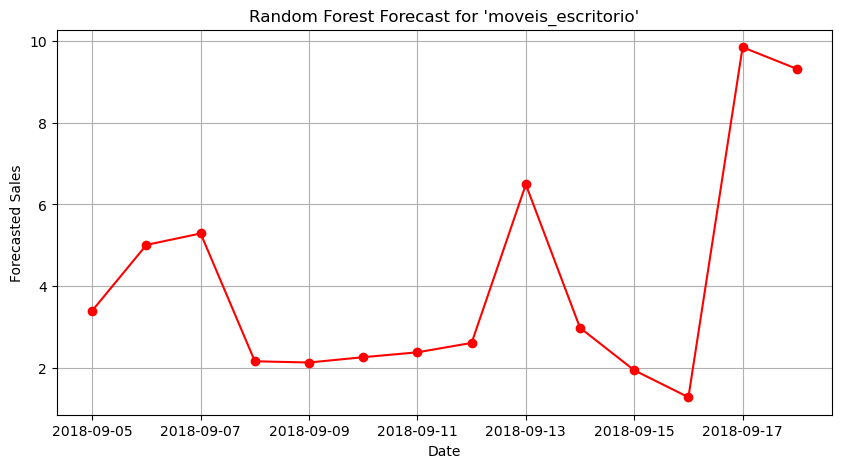

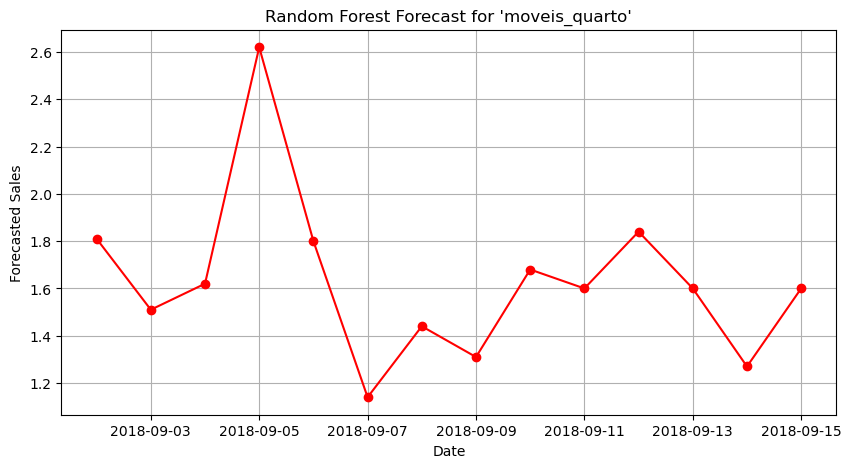

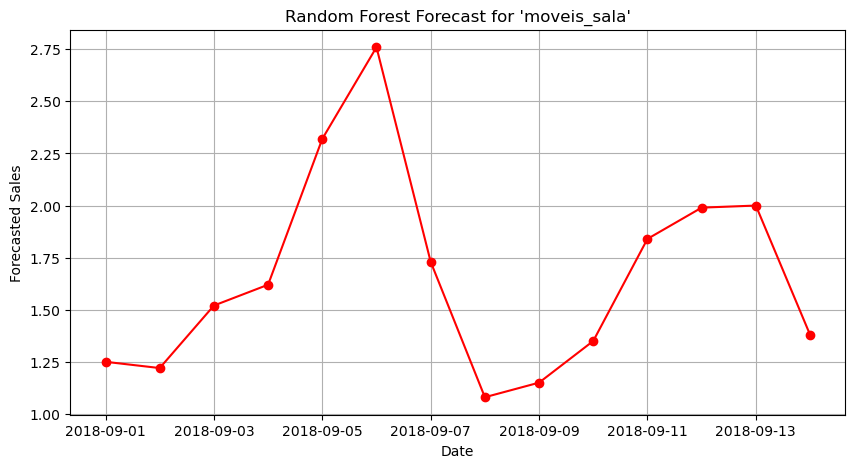

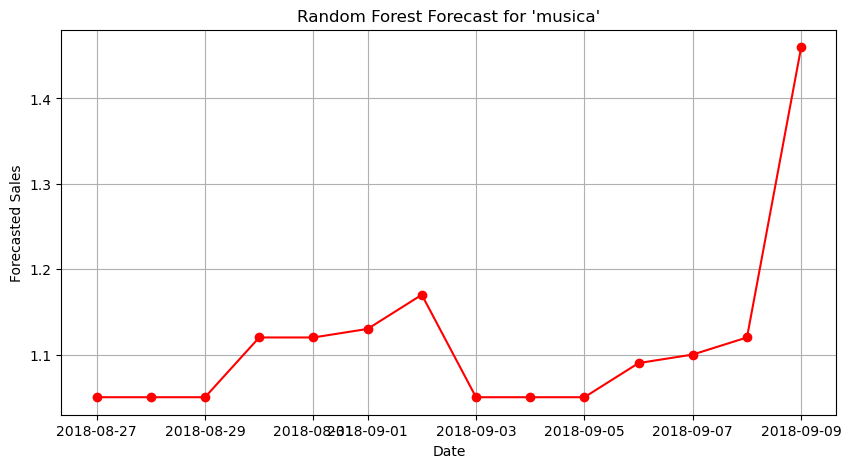

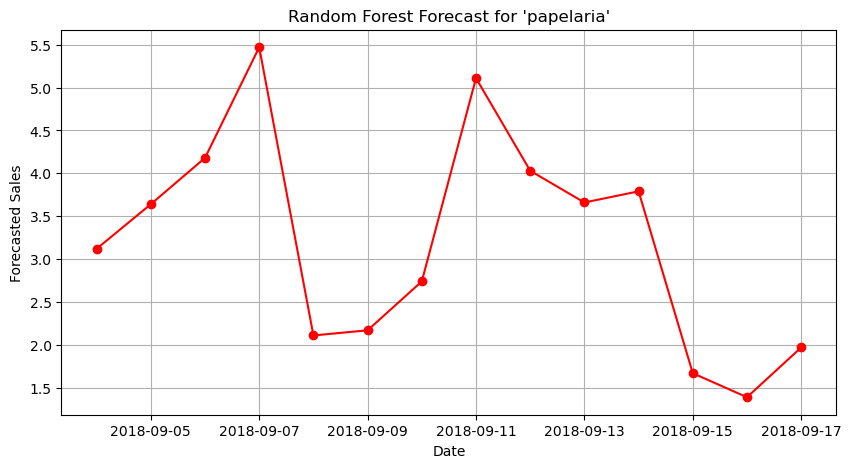

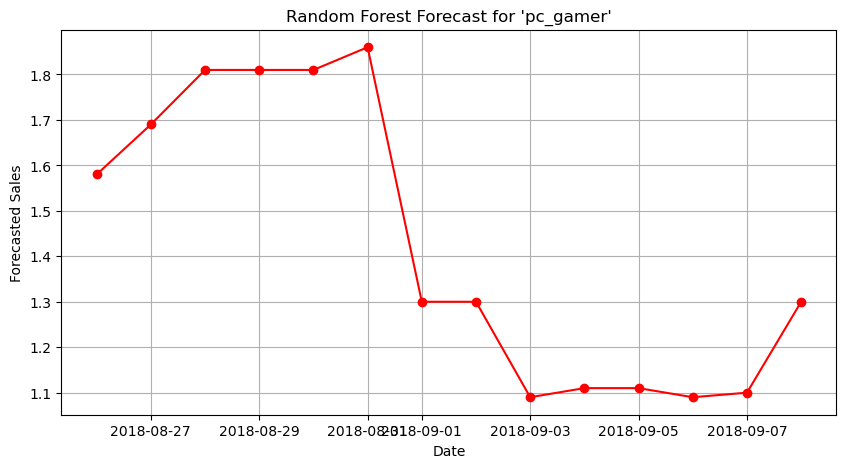

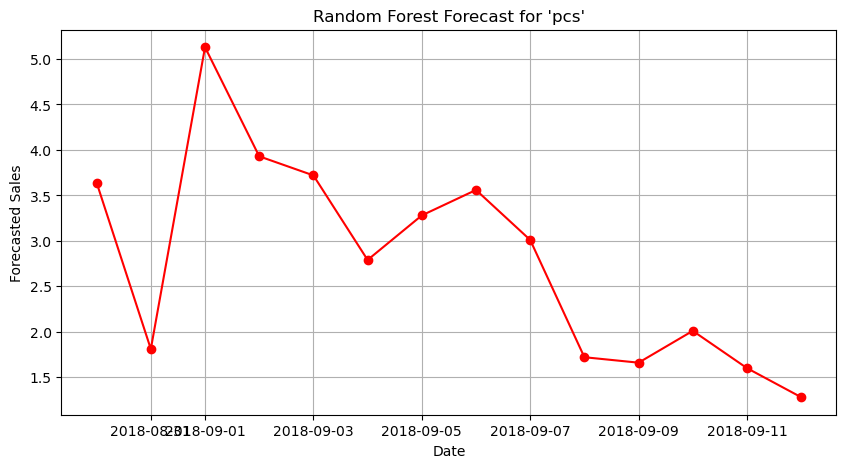

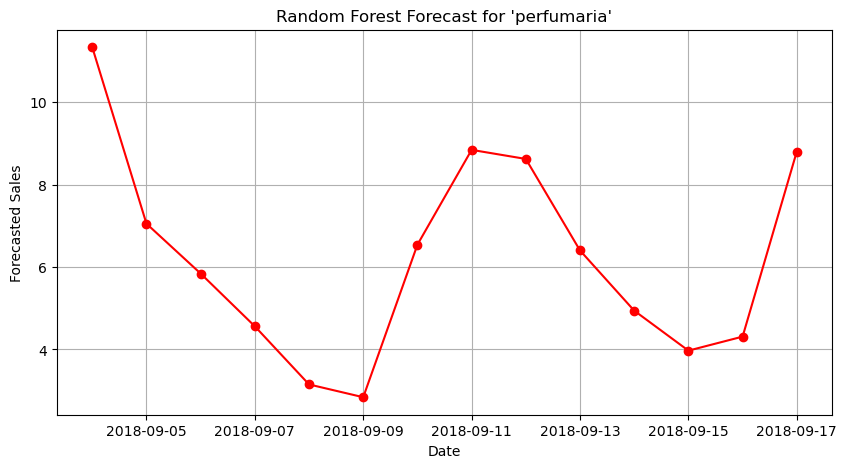

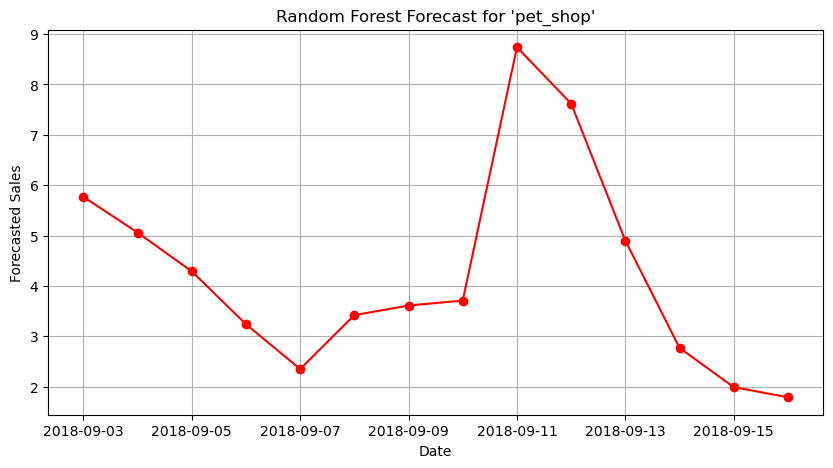

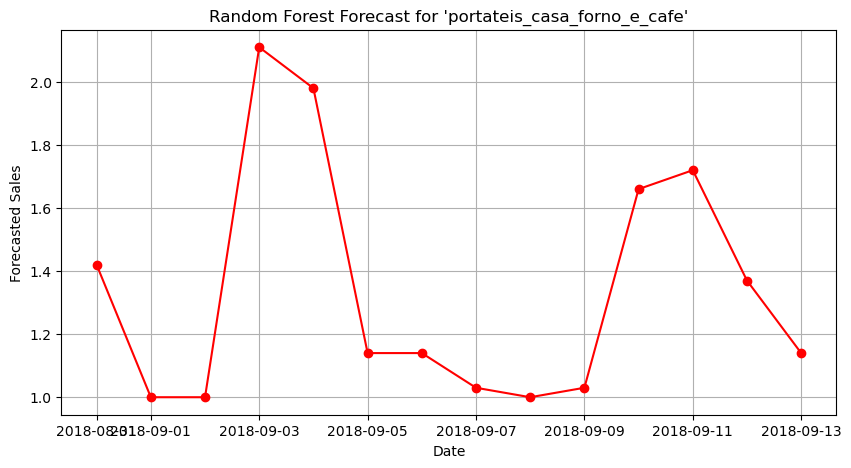

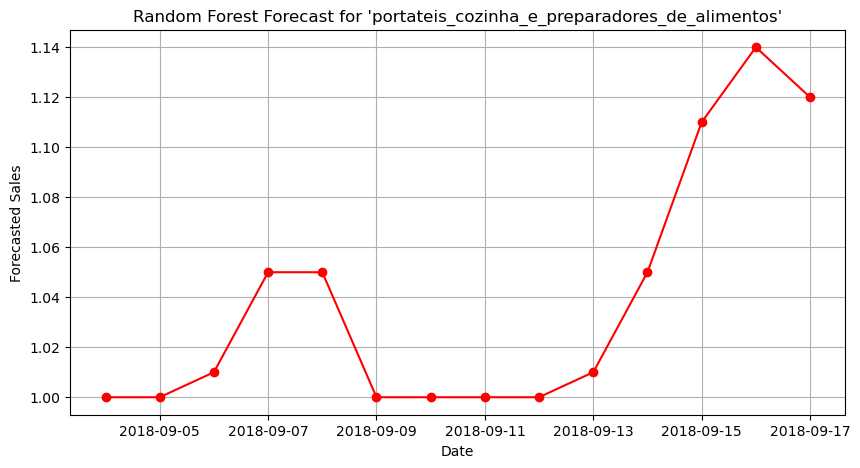

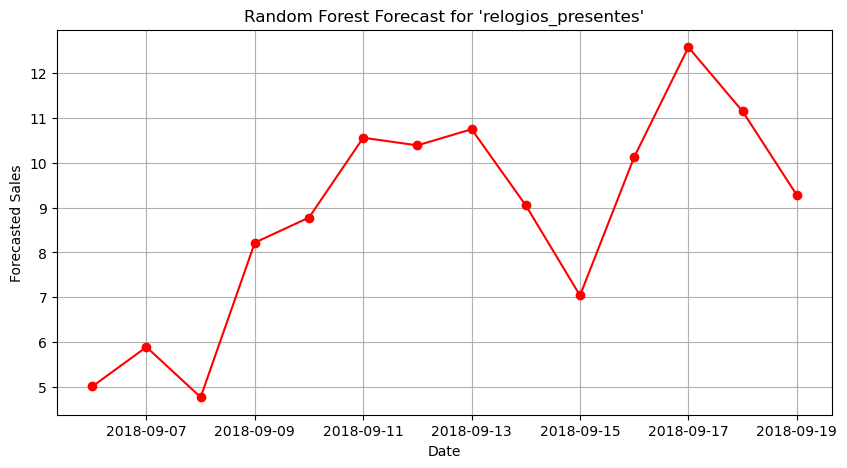

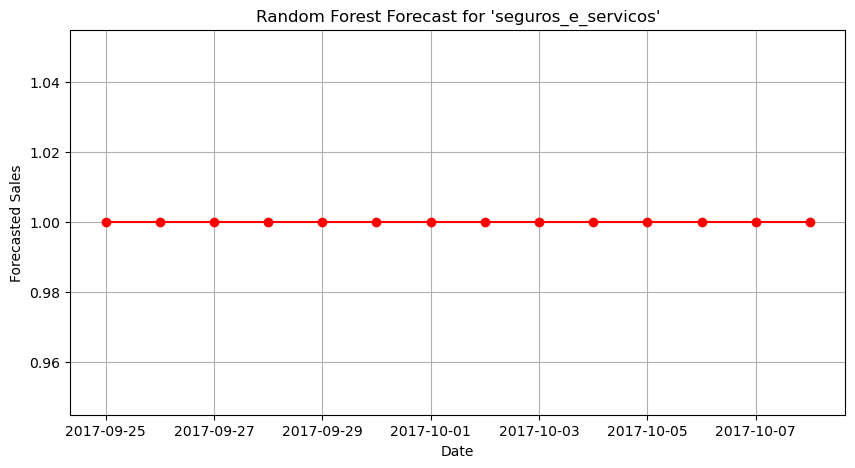

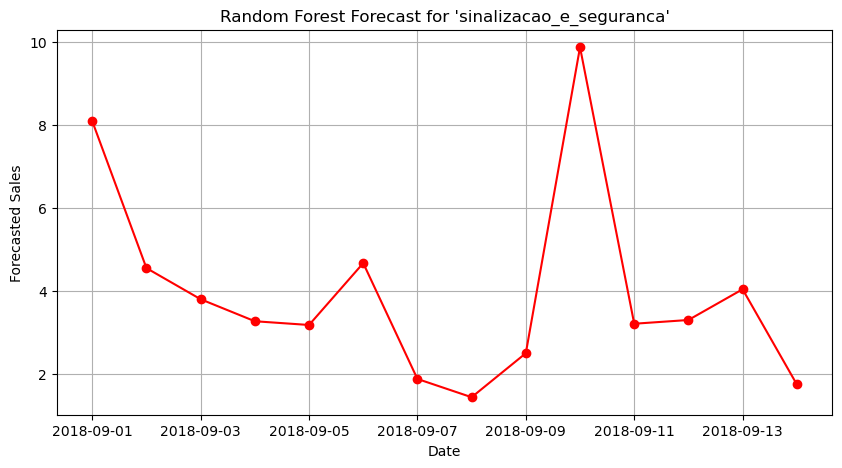

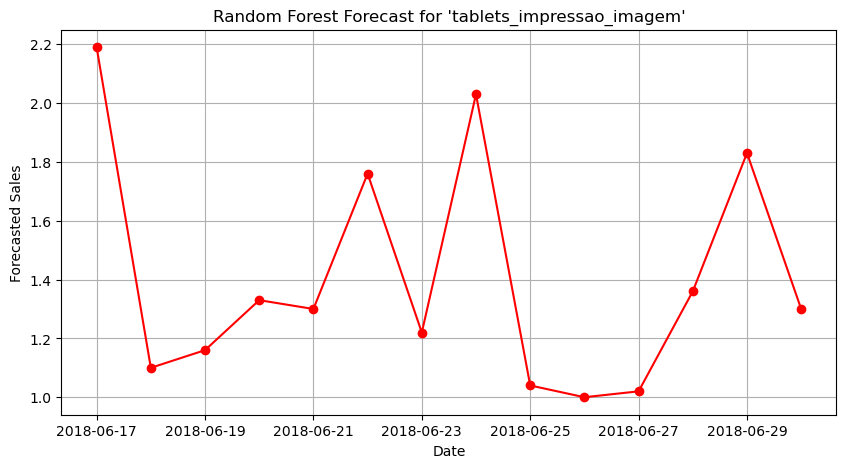

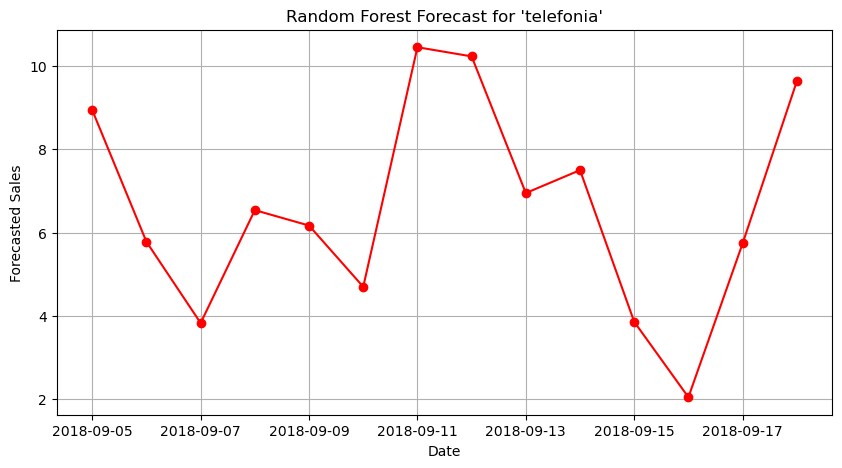

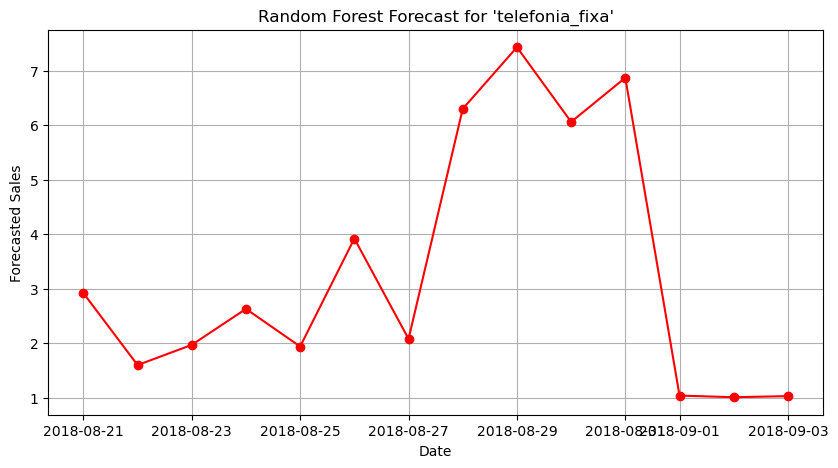

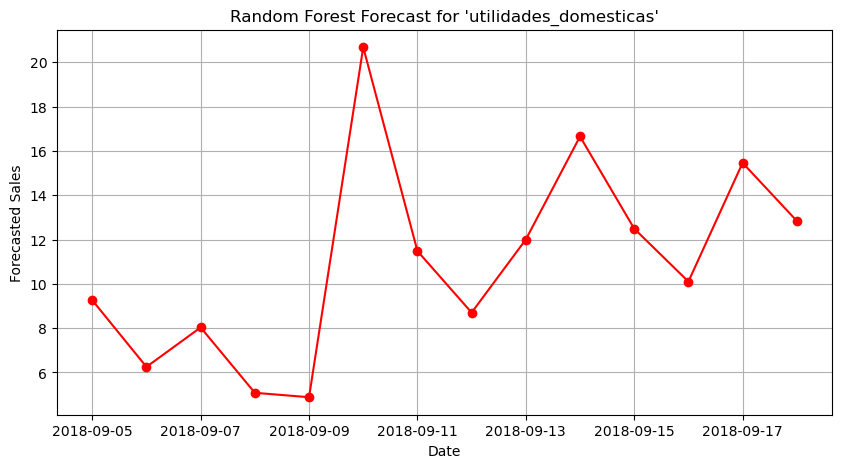

In [47]:
# Load and prepare daily sales data
sales = prepare_data("orders.csv", "order_items.csv", "products.csv")

# Check if data is loaded successfully
if not sales.empty:
    # Iterate over each product category and perform Random forest forecasting
    for category in sales['product_category_name'].unique():
        # Filter data for the current category
        category_data = sales[sales['product_category_name'] == category]
        # Train Random Forest model
        rf_model_2 = train_forest_model(category_data)
        # Make predictions for the next 14 days with a 7-day buffer
        rf_forecast_2, rf_dates_2 = prediction_rf(rf_model_2, category_data, days=14, buffer_days=7)
        plot_forecasts(rf_dates_2, rf_forecast_2, f"Random Forest Forecast for '{category}'")
else:
    print("Failed to load any data.")

In [49]:
# Checking if buffer zone worked
filtered_df = sales[sales['product_category_name'] == 'agro_industria_e_comercio']
last_date = filtered_df['date'].max()
last_date

Timestamp('2018-08-26 00:00:00')

### ARIMA

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.67 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2766.586, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2495.649, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=4.48 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2645.309, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=2426.654, Time=1.20 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.58 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.99 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2573.775, Time=0.55 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2372.853, Time=1.21 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=2442.462, Time=0.59 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.62 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=9.23 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2332.543, Time=1.50 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=2404.

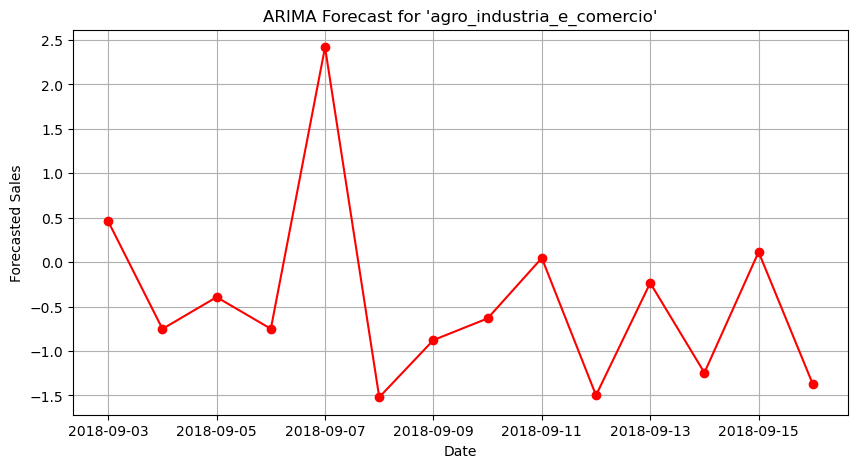

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=8.92 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3521.829, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3174.293, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.66 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3363.117, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3072.875, Time=1.03 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=10.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=4.26 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3236.702, Time=0.67 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=2982.212, Time=1.40 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=3076.867, Time=0.87 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=15.43 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=7.20 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=2947.317, Time=1.51 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=3035

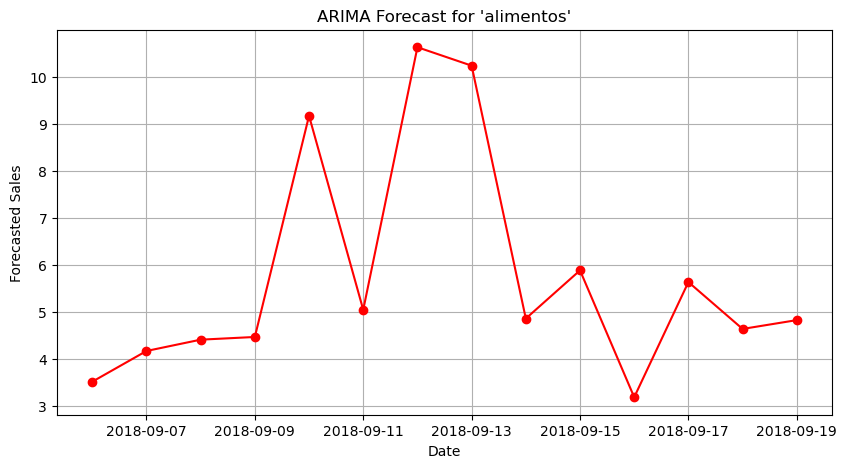

In [51]:
# Load and prepare daily sales data
sales = prepare_data("orders.csv", "order_items.csv", "products.csv")

# Count of currently created forecasts
iteration_count = 0
# How many forecasts to generate (Creating one forecast takes a lot of time, that's why it was implemented)
iteration_stop = 2

# Check if data is loaded successfully
if not sales.empty:
    # Iterate over each product category and perform ARIMA forecasting
    for category in sales['product_category_name'].unique():
        category_series = sales[sales['product_category_name'] == category].set_index('date').asfreq('D', fill_value=0)['num_sales']
        if check_if_data_exists(category_series):
            # Fit ARIMA model and make forecasts
            forecast_arima = fit_arima(category_series)
            if forecast_arima is not None:
                # Generate dates for ARIMA forecasts
                arima_dates = pd.date_range(start=category_series.index[-1], periods=22, freq='D')[8:22] # 22 days (7 buffer + 14 forecast)
                plot_forecasts(arima_dates, forecast_arima, f"ARIMA Forecast for '{category}'")
                
                iteration_count += 1
                if iteration_count == iteration_stop:
                    break
            else:
                print(f"ARIMA model could not be fitted for category: {category}.")
        else:
            print(f"No sufficient data to run ARIMA model for category: {category}.")
else:
    print("Failed to load any data.")

# Justification for the choice of methods

<b>Random Forest</b> is based on decision trees and combines multiple decision trees to make accurate predictions. It is often used to predict continuous values, such as predicting time series forecasting, stock prices, etc. The random tree model works well with large datasets and captures non-linear relationships between input and target variables.

<b>ARIMA</b> is a perfect example of classical time series forecasting approach. It is is a widely-used method for time series forecasting, particularly in cases where there are clear trends and seasonality in the data.